## Imports

In [2]:
from argparse import Namespace
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import DataLoader

from mednist import (
    MEDNISTDIR,
    download_mednist,
    get_mednist_files,
    MedNISTDataset,
    MedNISTTestDataset
)
from models import Autoencoder, VAE
from utils import plot, plot_anomaly_scores

# Select device to train on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Autoreload modules without restarting the kernel
%load_ext autoreload
%autoreload 2

## Config

In [3]:
config = Namespace()
config.batch_size = 128
config.val_split = 0.8
config.test_split = 0.9
config.device = device

## Download MedNIST and create DataLoader

In [4]:
# Download if necessary
download_mednist(MEDNISTDIR)

# Get all HeadCT and Hand files
head_ct_files = get_mednist_files(MEDNISTDIR, 'HeadCT')
hand_files = get_mednist_files(MEDNISTDIR, 'Hand')

# Create a training / validation / test split
val_split_idx = int(len(head_ct_files) * config.val_split)
test_split_idx = int(len(head_ct_files) * config.test_split)

# Take 8000 HeadCT images for training
train_files = head_ct_files[:val_split_idx]

# Take 1000 HeadCT images for validation
val_files = head_ct_files[val_split_idx:test_split_idx]

test_files_1 = head_ct_files[test_split_idx:]  # Take 1000 headCT images
test_files_2 = hand_files[test_split_idx:]  # And 1000 hand images for test
test_labels_1 = [0 for _ in range(len(test_files_1))]  # HeadCT are in-distribution -> 0
test_labels_2 = [1 for _ in range(len(test_files_2))]  # Hand are out-of-distribution -> 1
test_files = test_files_1 + test_files_2
test_labels = test_labels_1 + test_labels_2

# Create a training dataset with HeadCT files
train_ds = MedNISTDataset(train_files)
trainloader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

# Create a validation dataset with HeadCT files
val_ds = MedNISTDataset(val_files)
valloader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)

# Create a test dataset with HeadCT and Hand files
test_ds = MedNISTTestDataset(test_files, test_labels)
testloader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=True)

print('Train dataset size:', len(train_ds))
print('Batches in trainloader:', len(trainloader))

Train dataset size: 8000
Batches in trainloader: 63


### Show some images

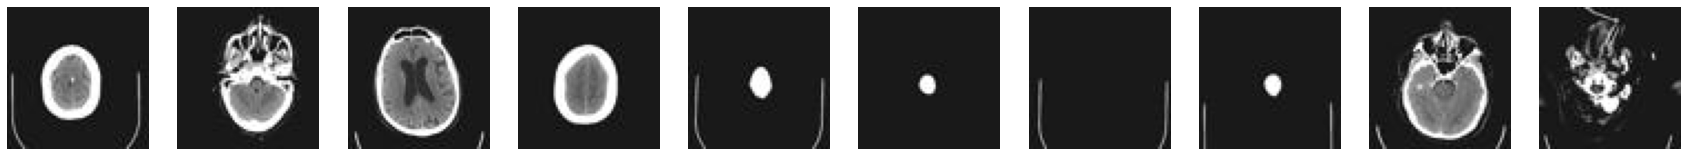

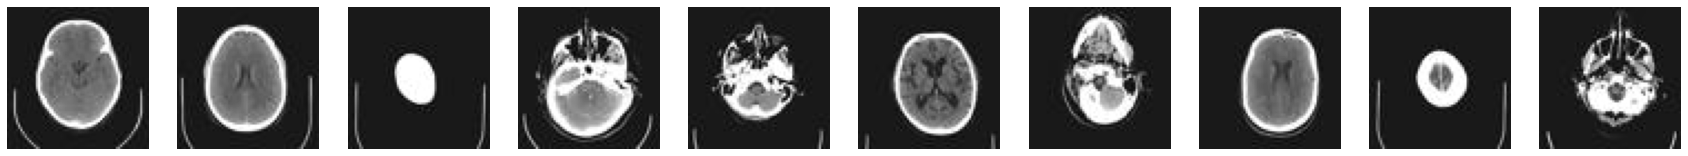

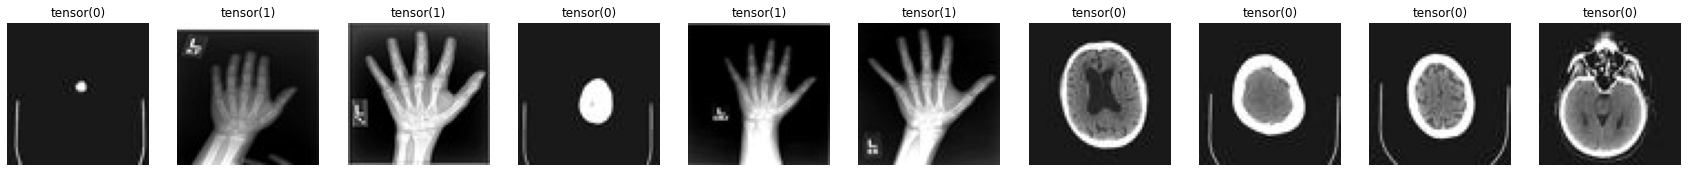

In [5]:
plot([img for img in next(iter(trainloader))[:10, 0]])
plot([img for img in next(iter(valloader))[:10, 0]])
imgs, labels = next(iter(testloader))
plot([img for img in imgs[:10, 0]], titles=labels[:10])

# Autoencoder 

In [6]:
config.latent_dim = 128
ae = Autoencoder(latent_dim=config.latent_dim)
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
  )
  (decoder_input): Sequential(
    (0): Linear(in_features=128, out_featu

In [7]:
def ae_train_step(ae, x, optimizer, device):
    ae.train()
    optimizer.zero_grad()
    x = x.to(device)
    x_recon = ae(x)
    loss = ae.loss_function(x, x_recon)  # MSE loss
    loss.backward()
    optimizer.step()
    return loss.item()


def ae_val_step(ae, x, device):
    ae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon = ae(x)
    return ae.loss_function(x, x_recon).item(), x_recon

In [8]:
 def train_ae(config, ae, optimizer, trainloader, valloader):
    i_step = 0
    i_epoch = 0
    all_losses = []
    losses = []
    ae.train()
    while True:
        for x in trainloader:
            # Train step
            loss = ae_train_step(ae, x, optimizer, config.device)

            # Store metrics
            losses.append(loss)
            all_losses.append(loss)

            # Log
            if i_step % config.log_frequency == 0:
                print(f'Iteration {i_step} - train loss {np.mean(losses):.4f}')
                losses = []

            # Validate
            if i_step % config.val_frequency == 0:
                val_loss, x_val, x_recon = validate_ae(config, ae, valloader)
                print(f'Iteration {i_step} - val loss {val_loss:.4f}')
                residual = torch.abs(x_val - x_recon)
                plot([x_val[0, 0], x_recon[0, 0], residual[0, 0]],
                     titles=['input', 'reconstruction', 'residual'])

            # Finish
            i_step += 1
            if i_step >= config.num_steps:
                print('Finished training')
                return ae
        i_epoch += 1
        print(f'Finished epoch {i_epoch}')


def validate_ae(config, ae, valloader):
    losses = []
    for x in valloader:
        loss, x_recon = ae_val_step(ae, x, config.device)
        losses.append(loss)
    return np.mean(losses), x.cpu(), x_recon.cpu()

Start training...
Iteration 0 - train loss 0.2670
Iteration 0 - val loss 0.1719


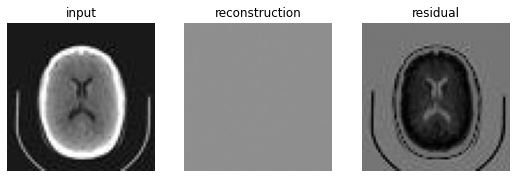

Iteration 50 - train loss 0.0472
Finished epoch 1
Iteration 100 - train loss 0.0221
Iteration 100 - val loss 0.0213


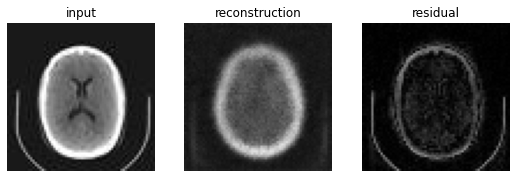

Finished epoch 2
Iteration 150 - train loss 0.0159
Finished epoch 3
Iteration 200 - train loss 0.0126
Iteration 200 - val loss 0.0116


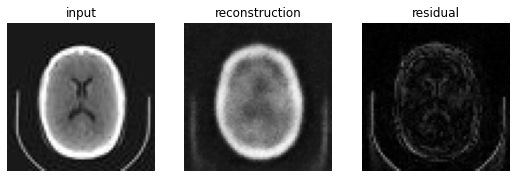

Iteration 250 - train loss 0.0106
Finished epoch 4
Iteration 300 - train loss 0.0094
Iteration 300 - val loss 0.0092


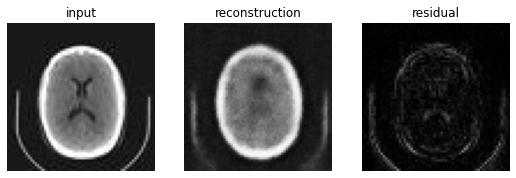

Finished epoch 5
Iteration 350 - train loss 0.0086
Finished epoch 6
Iteration 400 - train loss 0.0078
Iteration 400 - val loss 0.0077


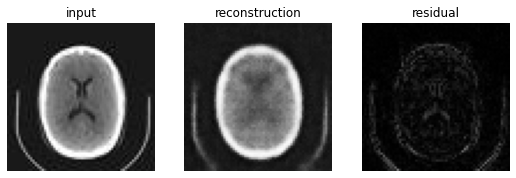

Finished epoch 7
Iteration 450 - train loss 0.0074
Iteration 500 - train loss 0.0068
Iteration 500 - val loss 0.0069


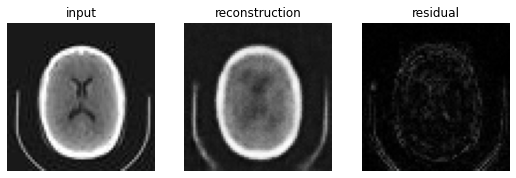

Finished epoch 8
Iteration 550 - train loss 0.0066
Finished epoch 9
Iteration 600 - train loss 0.0062
Iteration 600 - val loss 0.0063


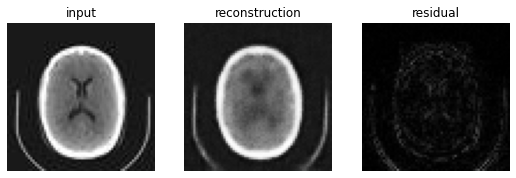

Finished epoch 10
Iteration 650 - train loss 0.0059
Finished epoch 11
Iteration 700 - train loss 0.0058
Iteration 700 - val loss 0.0059


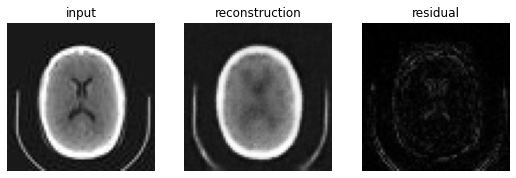

Iteration 750 - train loss 0.0056
Finished epoch 12
Iteration 800 - train loss 0.0055
Iteration 800 - val loss 0.0057


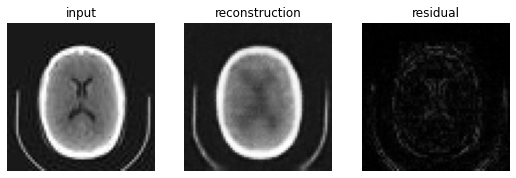

Finished epoch 13
Iteration 850 - train loss 0.0052
Finished epoch 14
Iteration 900 - train loss 0.0052
Iteration 900 - val loss 0.0054


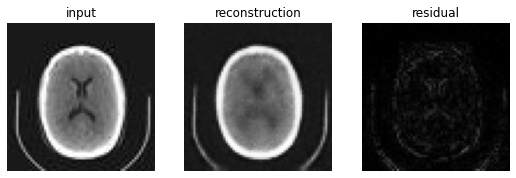

Finished epoch 15
Iteration 950 - train loss 0.0050
Finished training


In [9]:
# Train config
config.lr = 1e-3
config.num_steps = 1000
config.log_frequency = 50
config.val_frequency = 100

# Re-initialize Autoencoder
ae = Autoencoder(latent_dim=config.latent_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(ae.parameters(), lr=config.lr)

# Train
print('Start training...')
ae = train_ae(config, ae, optimizer, trainloader, valloader)

In [10]:
# Testing

def ae_test_step(ae, x, device):
    ae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon = ae(x)
    return x, x_recon, torch.abs(x - x_recon)

def test_ae(config, ae, testloader):
    scores = []
    labels = []
    ae.eval()
    for x, y in testloader:
        x, x_recon, residual = ae_test_step(ae, x, config.device)
        anomaly_score = torch.mean(residual, dim=(1, 2, 3))
        scores.extend(anomaly_score.cpu().numpy())
        labels.extend(y.numpy())

    return np.array(scores), np.array(labels)

ae_scores, ae_labels = test_ae(config, ae, testloader)

ROC AUC: 1.0000


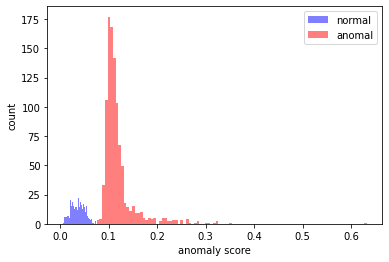

In [11]:
# Evaluation
auroc = roc_auc_score(ae_labels, ae_scores)
print(f'ROC AUC: {auroc:.4f}')

plot_anomaly_scores(ae_scores, ae_labels)

# Variational Autoencoder

In [12]:
def vae_train_step(vae, x, optimizer, device, kl_weight):
    vae.train()
    optimizer.zero_grad()
    x = x.to(device)
    x_recon, mu, logvar = vae(x)
    loss_dict = vae.loss_function(x, x_recon, mu, logvar, kl_weight)  # VAE loss
    loss = loss_dict['loss']
    loss.backward()
    optimizer.step()
    return loss_dict


def vae_val_step(vae, x, device, kl_weight):
    vae.eval()
    x = x.to(device)
    with torch.no_grad():
        x_recon, mu, logvar = vae(x)
    loss_dict = vae.loss_function(x, x_recon, mu, logvar, kl_weight)
    return loss_dict, x_recon.cpu()

In [13]:
 def train_vae(config, vae, optimizer, trainloader, valloader):
    i_step = 0
    i_epoch = 0
    all_losses = defaultdict(list)
    losses = defaultdict(list)
    config.kl_weight = config.batch_size / len(trainloader)
    vae.train()
    while True:
        for x in trainloader:
            # Train step
            loss_dict = vae_train_step(vae, x, optimizer, config.device,
                                       config.kl_weight)

            # Store metrics
            for k, v in loss_dict.items():
                losses[k].append(v.item())
                all_losses[k].append(v.item())

            # Log
            if i_step % config.log_frequency == 0:
                losses = {k: np.mean(v) for k, v in losses.items()}
                log_msg = f'Iteration {i_step}'
                for k, v in losses.items():
                    log_msg += f' - {k}: {v:.4f}'
                print(log_msg)
                losses = defaultdict(list)

            # Validate
            if i_step % config.val_frequency == 0:
                val_losses, x_val, x_recon = validate_vae(config, vae, valloader)
                log_msg = f'Iteration {i_step}'
                for k, v in val_losses.items():
                    log_msg += f' - val {k}: {v:.4f}'
                print(log_msg)
                residual = torch.abs(x_val - x_recon)
                plot([x_val[0, 0], x_recon[0, 0], residual[0, 0]],
                     titles=['input', 'reconstruction', 'residual'])

            # Finish
            i_step += 1
            if i_step >= config.num_steps:
                print('Finished training')
                return vae
        i_epoch += 1
        print(f'Finished epoch {i_epoch}')


def validate_vae(config, vae, valloader):
    losses = defaultdict(list)
    for x in valloader:
        loss_dict, x_recon = vae_val_step(vae, x, config.device,
                                          config.kl_weight)
        for k, v in loss_dict.items():
            losses[k].append(v.item())
    losses = {k: np.mean(v) for k, v in losses.items()}
    return losses, x.cpu(), x_recon.cpu()

Start training...
Iteration 0 - loss: 32.0787 - recon_loss: 0.2482 - kl_loss: 15.6666
Iteration 0 - val loss: 0.5554 - val recon_loss: 0.1819 - val kl_loss: 0.1838


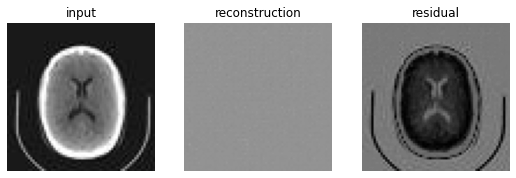

Iteration 50 - loss: 86.8148 - recon_loss: 0.0715 - kl_loss: 42.6940
Finished epoch 1
Iteration 100 - loss: 2.4157 - recon_loss: 0.0437 - kl_loss: 1.1674
Iteration 100 - val loss: 1.7034 - val recon_loss: 0.0428 - val kl_loss: 0.8173


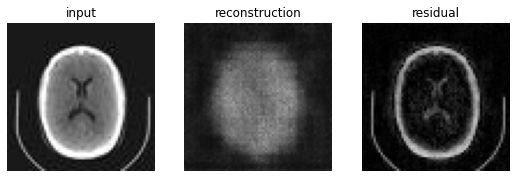

Finished epoch 2
Iteration 150 - loss: 1.2647 - recon_loss: 0.0418 - kl_loss: 0.6019
Finished epoch 3
Iteration 200 - loss: 0.8824 - recon_loss: 0.0411 - kl_loss: 0.4141
Iteration 200 - val loss: 0.7883 - val recon_loss: 0.0415 - val kl_loss: 0.3676


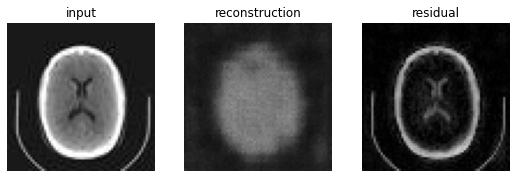

Iteration 250 - loss: 0.6884 - recon_loss: 0.0410 - kl_loss: 0.3186
Finished epoch 4
Iteration 300 - loss: 0.5718 - recon_loss: 0.0408 - kl_loss: 0.2613
Iteration 300 - val loss: 0.5594 - val recon_loss: 0.0413 - val kl_loss: 0.2550


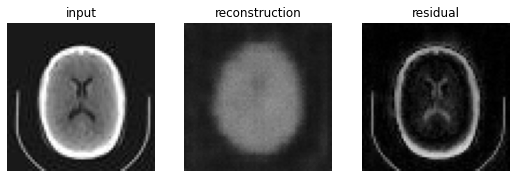

Finished epoch 5
Iteration 350 - loss: 0.4751 - recon_loss: 0.0408 - kl_loss: 0.2137
Finished epoch 6
Iteration 400 - loss: 0.4240 - recon_loss: 0.0406 - kl_loss: 0.1887
Iteration 400 - val loss: 0.4431 - val recon_loss: 0.0410 - val kl_loss: 0.1979


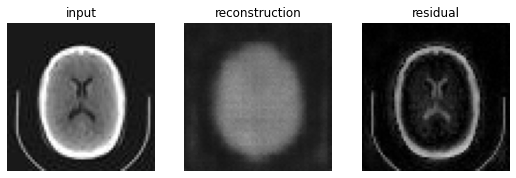

Finished epoch 7
Iteration 450 - loss: 0.3907 - recon_loss: 0.0407 - kl_loss: 0.1723
Iteration 500 - loss: 0.3354 - recon_loss: 0.0406 - kl_loss: 0.1451
Iteration 500 - val loss: 0.3819 - val recon_loss: 0.0411 - val kl_loss: 0.1677


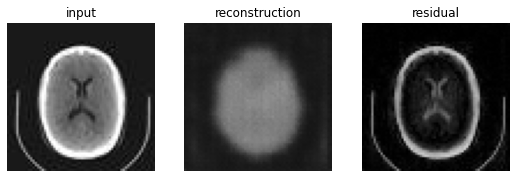

Finished epoch 8
Iteration 550 - loss: 0.3511 - recon_loss: 0.0406 - kl_loss: 0.1528
Finished epoch 9
Iteration 600 - loss: 0.3478 - recon_loss: 0.0404 - kl_loss: 0.1513
Iteration 600 - val loss: 0.3459 - val recon_loss: 0.0408 - val kl_loss: 0.1502


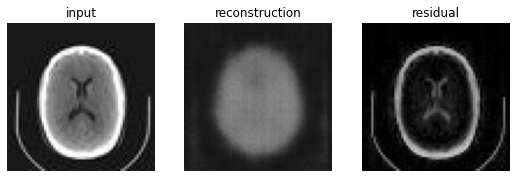

Finished epoch 10
Iteration 650 - loss: 0.3617 - recon_loss: 0.0405 - kl_loss: 0.1581
Finished epoch 11
Iteration 700 - loss: 0.3822 - recon_loss: 0.0403 - kl_loss: 0.1683
Iteration 700 - val loss: 0.3660 - val recon_loss: 0.0407 - val kl_loss: 0.1601


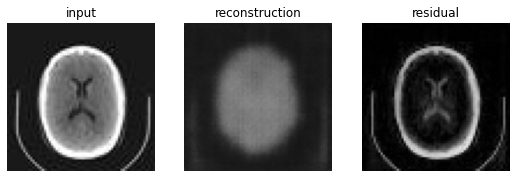

Iteration 750 - loss: 0.4196 - recon_loss: 0.0404 - kl_loss: 0.1866
Finished epoch 12
Iteration 800 - loss: 0.5023 - recon_loss: 0.0404 - kl_loss: 0.2273
Iteration 800 - val loss: 0.4059 - val recon_loss: 0.0408 - val kl_loss: 0.1797


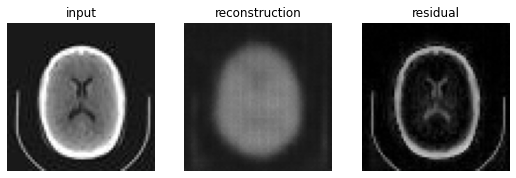

Finished epoch 13
Iteration 850 - loss: 0.5078 - recon_loss: 0.0403 - kl_loss: 0.2301
Finished epoch 14
Iteration 900 - loss: 0.5245 - recon_loss: 0.0404 - kl_loss: 0.2383
Iteration 900 - val loss: 0.6844 - val recon_loss: 0.0409 - val kl_loss: 0.3167


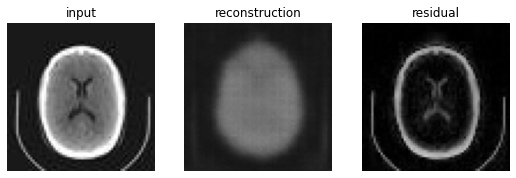

Finished epoch 15
Iteration 950 - loss: 0.8475 - recon_loss: 0.0403 - kl_loss: 0.3973
Finished training


In [14]:
# Initialize Variational Autoencoder
vae = VAE(latent_dim=config.latent_dim).to(device)

# Optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=config.lr)

# Train
print('Start training...')
vae = train_vae(config, vae, optimizer, trainloader, valloader)

In [15]:
# Testing VAE

def vae_test_step(vae, x, device):
    vae.eval()
    x = x.to(device)
    with torch.no_grad():
        anomaly_scores = vae.anomaly_score(x)
    return anomaly_scores.cpu()

def test_vae(config, vae, testloader):
    scores = []
    labels = []
    vae.eval()
    for x, y in testloader:
        anomaly_scores = vae_test_step(vae, x, config.device)
        scores.extend(anomaly_scores.numpy())
        labels.extend(y.numpy())

    return np.array(scores), np.array(labels)

vae_scores, vae_labels = test_vae(config, vae, testloader)

ROC AUC: 0.9998


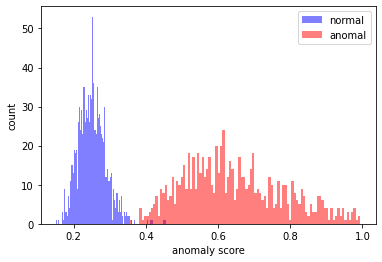

In [16]:
# Evaluation
auroc = roc_auc_score(vae_labels, vae_scores)
print(f'ROC AUC: {auroc:.4f}')

plot_anomaly_scores(vae_scores, vae_labels)